In [1]:
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from rich import print
from IPython.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

## Integrating with Genius

[Genius](http://ii.tudelft.nl/genius/) is a commonly used automated negotiation research platform implemented in Java. It was used to run [ANAC](http://web.tuat.ac.jp/~katfuji/ANAC2024/) and has hundreds of implemented negotiation strategy for the AOP and SAOP negotiation protocols. It supports other protocols but few existing negotiation strategies are available for any protocols other than AOP and SAOP.

NegMAS provides a bridge allowing you to run Genius agents and NegMAS negotiators. This bridge **does not** come bundled with NegMAS.

### Installing the bridge

After installing NegMAS, you can download and prepare the bridge by running the following command in your terminal:

```bash
negmas genius-setup
```

You can check that everything is OK by running:

```bash
java -jar $HOME/negmas/files/geniusbridge.jar --version
```

#### Direct Download

You can also just download the bridge [here](https://yasserfarouk.github.io/files/geniusbdidge.jar) and copy it to a folder `files` under `negmas` in your home directory. For Linx and macOS, you can just run:

```bash
curl https://yasserfarouk.github.io/files/geniusbridge.jar --create-dirs -o $HOME/negmas/files/geniusbridge.jar
```

For Windows, open a power-shell terminal and run:

```PowerShell
Invoke-WebRequest -Uri https://yasserfarouk.github.io/files/geniusbridge.jar -OutFile $HOME\negmas\files\geniusbridge.jar
```

### Running the bridge [Optional]

Whenever you want to use a Genius agent from negmas, it is recommended (but not necessary) to explicitly run the bridge using:

```bash
negmas genius
```

If this did not work, make sure that you have a compatible Java version installed (our tests are run using Open JDK 18 but any modern java version should work). You can also run the bridge directly using:

```bash
java -jar $HOME/negmas/files/geniusbridge.jar
```

You should get something like:

```
received options:
Gateway 0.4.13 to python started at port 25337 listening to port 25337 [forcing timeout: 1800000ms]
```

### Getting an example scenario

You can create any scenario as described in the previous tutorial. For this tutorial, we want to showcase the use of `Scenario.load` to load a scenario from the secondry storage.

Firstly, let's get a negotiation scenario into your machine to use for this experiment. You can download an example domain [here](https://yasserfarouk.github.io/files/CameraB.zip), and unzip it to some place in your hard-disk to use later for the negotiation. Or just run the following command to download it to `negmas/scenarios/CameraB` under your home directory:

- On Linux and 
  ```bash
  curl https://yasserfarouk.github.io/files/CameraB.zip --create-dirs -o $HOME/negmas/scenarios/CameraB.zip
  unzip $HOME/negmas/scenarios/CameraB.zip -d $HOME/negmas/scenarios/
  rm $HOME/negmas/scenarios/CameraB.zip
  ```
- On Windows (You'll need an unzip utility like [7-Zip](https://www.7-zip.org/) installed for this script to work.)
  ```PowerShell  
  Invoke-WebRequest -Uri https://yasserfarouk.github.io/files/CameraB.zip -OutFile $HOME/negmas/scenarios/CameraB.zip
  7z x $HOME/negmas/scenarios/CameraB.zip -o$HOME\negmas\scenarios
  Remove-Item $HOME/negmas/scenarios/CameraB.zip
  ```

In [2]:
!curl https://yasserfarouk.github.io/files/CameraB.zip --create-dirs -o $HOME/negmas/scenarios/CameraB.zip
!yes A | unzip $HOME/negmas/scenarios/CameraB.zip -d $HOME/negmas/scenarios/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   162  100   162    0     0   1322      0 --:--:-- --:--:-- --:--:--  1327
Archive:  /Users/yasser/negmas/scenarios/CameraB.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /Users/yasser/negmas/scenarios/CameraB.zip or
        /Users/yasser/negmas/scenarios/CameraB.zip.zip, and cannot find /Users/yasser/negmas/scenarios/CameraB.zip.ZIP, period.
yes: stdout: Broken pipe


### Running a negotiation from the command line

Now we are ready to try the bridge from the command line:

```bash
negotiate $HOME/negmas/scenarios/CameraB --no-plot -p sao -n AspirationNegotiator -n genius.BoulwareNegotiationParty --steps=100
```

You should get something like:

![negexample](../figs/negexample.jpg)

You can also visualize the negotiation using:

```bash
negotiate $HOME/negmas/scenarios/CameraB --plot -p sao -n AspirationNegotiator -n genius.BoulwareNegotiationParty --steps=100
```

![negplot](../figs/negplot.jpg)


*If you did not explicitly run the bridge, you may get an error the first time you try running a negotiation with a Genius agent involved that the system "Cannot start the bridge". Just try again or run the bridge explicitly as described in the previous section*

### Running a negotiation in python

You can run a negotiation that has some Genius negotiators in them in python almost as easily as running a negotiation between two native NegMAS negotiators. Here is an example using the scenario we just saved:

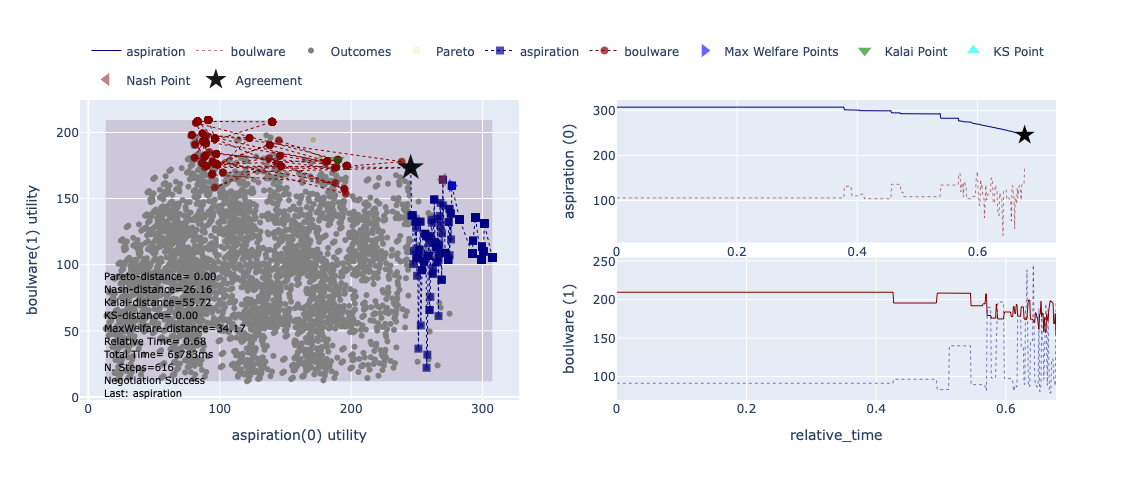

In [3]:
from pathlib import Path
from negmas.inout import Scenario
from negmas.scenarios import load_scenario
from negmas.sao.negotiators import AspirationNegotiator
from negmas.genius.gnegotiators import BoulwareNegotiationParty

scenario = load_scenario("CameraB")
session = scenario.make_session(time_limit=10)
session.add(AspirationNegotiator(preferences=scenario.ufuns[0], name="aspiration"))
session.add(BoulwareNegotiationParty(preferences=scenario.ufuns[1], name="boulware"))
session.run()
session.plot()

As you can see, there is no difference between using a native NegMAS negotiator and a Genius Negotiator except in where you import it from. For NegMAS SAO negotiators, you use `negmas.sao.negotiators` and for genius negotiators you use `negmas.genius.gnegotiators`. Everything else is the same.

You can even run a negotiation between two Genius negotiators directly:

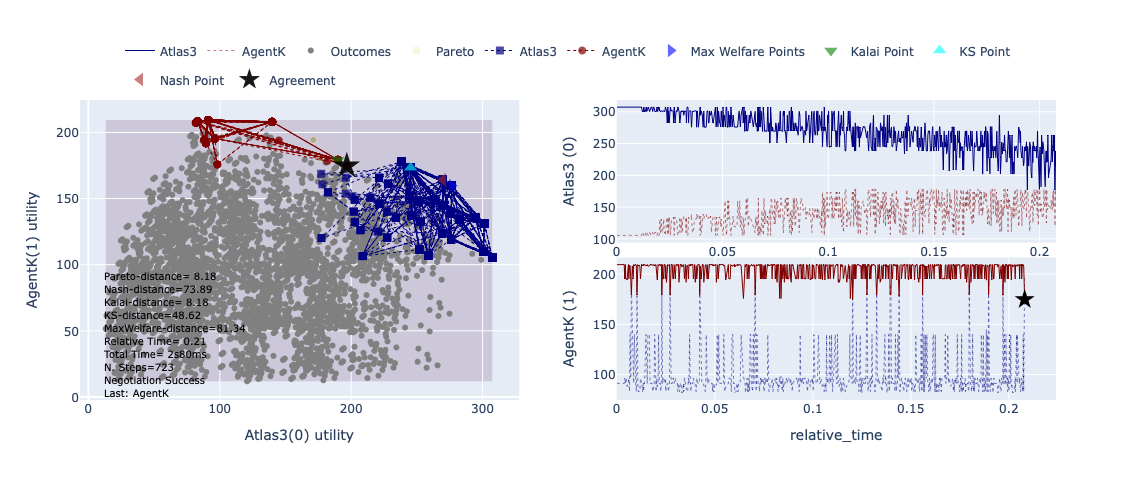

In [4]:
from negmas.genius.gnegotiators import Atlas3, AgentK

session = scenario.make_session(time_limit=10)
session.add(Atlas3(preferences=scenario.ufuns[0], name="Atlas3"))
session.add(AgentK(preferences=scenario.ufuns[1], name="AgentK"))
session.run()
session.plot()

### How does it work?

This integration is supported by the [GeniusNegotiator](https://negmas.readthedocs.io/en/latest/api/negmas.genius.GeniusNegotiator.html). This class, presents Genius agents as [SAONegotiator](https://negmas.readthedocs.io/en/latest/api/negmas.sao.SAONegotiator.html) objects to NegMAS. The most important difference between a `GeniusNegotiator` and a normal `SAONegotiator` from the user's point of view is the way they are constructed. A `GeniusNegotiator` has the following extra parameters in its `__init__()` function:

- java_class_name (str | None) – The java class name of the Geinus underlying agent
- domain_file_name (str | Path | None) – Optional domain file name (containing the negotiation issues or agenda)
- utility_file_name (str | Path | None) – Optional ufun file name (xml) from which a ufun will be loaded for the agent- 
- auto_load_java (bool) – Load the genius bridge if needed
- port (int) – The port to load the genius bridge to (or use if it is already loaded)
- genius_bridge_path (str | None) – The path to the genius bridge

Inside `genius.gnegotiators` we simply create classes for all Genius agents like this:

```python
class Atlas3(GeniusNegotiator):
    def __init__(self, **kwargs):
        kwargs["java_class_name"] = "agents.anac.y2015.Atlas3.Atlas3"
        super().__init__(**kwargs)
```

If you missed any Genius agent, you can add it by just passing the `java_class_name` parameter during construction in the same way.

Let's try to run the same negotiation above without using `gnegotiators` at all:


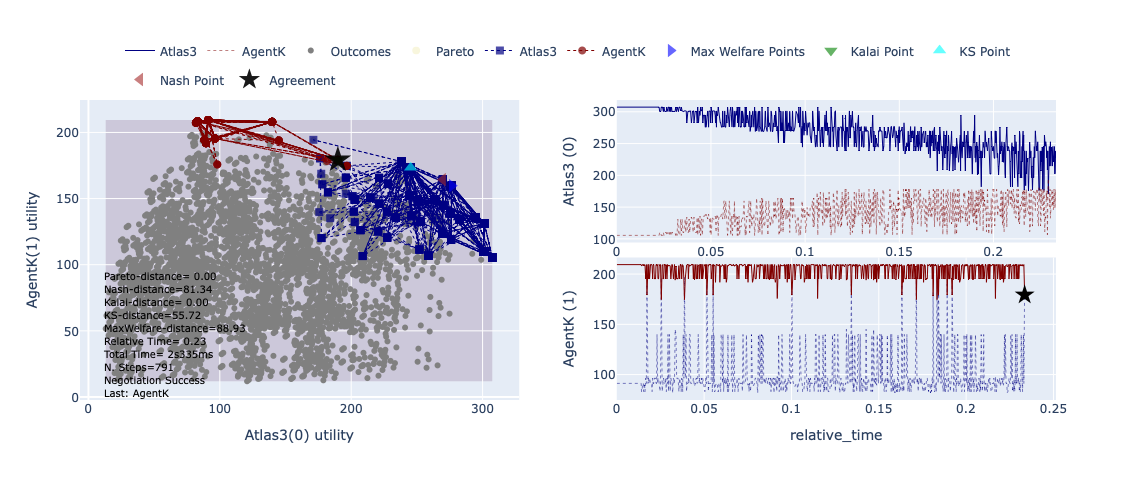

In [5]:
from negmas.genius import GeniusNegotiator

session = scenario.make_session(time_limit=10)
session.add(
    GeniusNegotiator(
        java_class_name="agents.anac.y2015.Atlas3.Atlas3",
        preferences=scenario.ufuns[0],
        name="Atlas3",
    )
)
session.add(
    GeniusNegotiator(
        java_class_name="agents.anac.y2010.AgentK.Agent_K",
        preferences=scenario.ufuns[1],
        name="AgentK",
    )
)
session.run()
session.plot()